In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#!pip install pandas
#!pip install tqdm

#!pip install scipy
#!pip install matchms
#!pip install scikit-learn
#!pip install spec2vec
#!pip install seaborn

In [3]:
import os
os.chdir('/Users/sebas/projects/metabolomics')
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [4]:
from src.transformers.sklearn_model import SklearnModel

Seed set to 42


In [49]:
import gensim
from src.load_data import LoadData
from src.config import Config
from matchms import calculate_scores
from matchms.importing import load_from_mgf,load_from_msp
import matchms.filtering as msfilters
from spec2vec import SpectrumDocument
from spec2vec.model_building import train_new_word2vec_model
from tqdm import tqdm
from src.loader_saver import LoaderSaver
import itertools
import numpy as np
from matchms.importing import load_from_msp
from matchms.similarity import ModifiedCosine
from scipy.stats import spearmanr
import dill
from src.plotting import Plotting
from src.load_data import LoadData
from sklearn.model_selection import train_test_split
from src.train_utils import TrainUtils
from src.preprocessor import Preprocessor
from matchms.filtering import add_fingerprint
import pickle
import sys
from src.config import Config
from src.parser import Parser
from datetime import datetime
from src.loader_saver import LoaderSaver
from src.spec2vec_comparison import Spec2VecComparison
from src.ms2deepscore_comparison import MS2DeepScoreComparison
from src.molecular_pairs_set import MolecularPairsSet
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

In [6]:
from src.transformers.embedder import Embedder

In [7]:
ls /Users/sebas/projects/data

ALL_GNPS_NO_PROPOGATED_wb.mgf
GNPS-NIH-NATURALPRODUCTSLIBRARY.mgf
all_spectrums_gnps.pkl
all_spectrums_gnps_nist_20240130_gnps_nist_janssen.pkl
all_spectrums_janssen.pkl
all_spectrums_nist.pkl
best_model.ckpt
best_model_128n_10_layers_20240209.ckpt
best_model_128n_5_layers_20240219_elementwise.ckpt
drug_plus.mgf
hr_msms_nist_all.MSP*
hr_msms_nist_sample.MSP
merged_gnps_nist_20240118_gnps_nist_janssen.pkl
merged_gnps_nist_20240207_gnps_nist_janssen_15_millions.pkl
ms2deepscore_positive_10k_1000_1000_1000_500.hdf5
spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model
spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model.trainables.syn1neg.npy
spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model.wv.vectors.npy
to_export_gnps_nist.pkl
uniformed_molecule_pairs_test.pkl


## Parameters

In [8]:
data_folder= '/Users/sebas/projects/data/'
dataset_path = data_folder + 'uniformed_molecule_pairs_test.pkl'
gnps_path =  data_folder + 'ALL_GNPS_NO_PROPOGATED_wb.mgf'
janssen_path = data_folder + 'drug_plus.mgf'
nist_path = data_folder + 'hr_msms_nist_all.MSP'
output_pairs_file= data_folder + 'molecular_pairs.pkl'
output_nist_file= data_folder + 'all_spectrums_nist.pkl'
output_gnps_file= data_folder + 'all_spectrums_gnps.pkl'
output_janssen_file= data_folder + 'all_spectrums_janssen.pkl'
model_spec2vec_file = data_folder + 'spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model'
model_ms2d_file= data_folder + 'ms2deepscore_positive_10k_1000_1000_1000_500.hdf5'
#uniformed_molecule_pairs_test_path= data_folder +'uniformed_molecule_pairs_test.pkl'
uniformed_molecule_pairs_test_path= data_folder +'merged_gnps_nist_20240207_gnps_nist_janssen_15_millions.pkl'
transformer_path = data_folder + 'best_model_128n_5_layers_20240219_elementwise.ckpt'

In [9]:
THRESHOLD_ANALOG=0.7

In [10]:
load_molecule_pairs_file= True
only_use_gnps=False

In [11]:
## Load spectrum using spectrumutils

In [12]:
config=Config()

In [13]:
all_spectrums_gnps_MATCHMS = [(s) for s in load_from_mgf(gnps_path)]

In [14]:
all_spectrums_janssen_MATCHMS = [(s) for s in load_from_mgf(janssen_path)]

2024-02-20 13:19:51,800:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-02-20 13:19:51,802:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-02-20 13:19:51,802:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-02-20 13:19:51,803:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-02-20 13:19:51,804:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-02-20 13:19:51,804:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-02-20 13:19:51,805:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-02-20 13:19:51,806:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-02-20 13:19:51,806:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-02-20 13:19:51,807:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-02-20 13:19:51,808:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-02-20 13:19:51,808:WARNING:matchms:add

In [15]:
#all_spectrums_nist_MATCHMS = list(itertools.islice(load_from_msp(nist_path), 30000))
all_spectrums_nist_MATCHMS = [s for s in load_from_msp(nist_path)]

In [16]:
len(all_spectrums_gnps_MATCHMS),len(all_spectrums_janssen_MATCHMS),len(all_spectrums_nist_MATCHMS)

(504840, 2546, 1026712)

In [17]:
all_spectrums_MATCHMS = all_spectrums_gnps_MATCHMS + all_spectrums_janssen_MATCHMS + all_spectrums_nist_MATCHMS

## Load molecular pairs

In [18]:

if load_molecule_pairs_file:
        with open(uniformed_molecule_pairs_test_path, 'rb') as file:
            dataset = dill.load(file)
        original_molecule_pairs= dataset['uniformed_molecule_pairs_test']
else:
        number_pairs=10000
        original_molecule_pairs= TrainUtils.compute_all_tanimoto_results(all_spectrums, 
                                                                max_combinations=number_pairs, 
                                                                use_tqdm=True, 
                                                                max_mass_diff=config.MAX_MASS_DIFF, 
                                                                min_mass_diff=config.MIN_MASS_DIFF)

In [19]:
len(original_molecule_pairs)

185165

In [20]:
if only_use_gnps:
    molecule_pairs = original_molecule_pairs.get_gnps_pairs()
else:
    molecule_pairs=original_molecule_pairs

In [21]:
len(molecule_pairs)

185165

## Our model

In [22]:
from src.transformers.sklearn_model import SklearnModel

In [23]:
temp_molecule_pairs= MolecularPairsSet(spectrums= molecule_pairs.spectrums, 
                                      indexes_tani =molecule_pairs.indexes_tani)

In [24]:
#model = Embedder.load_from_checkpoint(
 #           checkpoint_path=transformer_path, d_model=config.D_MODEL, n_layers=config.N_LAYERS
#        )

In [25]:
model =SklearnModel(model_path=transformer_path, d_model=config.D_MODEL, n_layers=config.N_LAYERS)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [26]:
#next(iter(dataloader_test))

In [27]:
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] 

'1'

In [28]:
scores_trans=model.predict_from_molecule_pair(temp_molecule_pairs)

Preprocessing all the data ...


32486it [00:01, 19428.06it/s]


Finished preprocessing 
Starting the loading of the data ...
Normalizing intensities
Creating dictionaries
Preprocessing all the data ...


32486it [00:00, 76242.62it/s]


Finished preprocessing 
Starting the loading of the data ...
Normalizing intensities
Creating dictionaries


/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                            | 0/? [00:00<?, ?it/s]

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
The operator 'aten::_nested_tensor_from_mask_left_aligned' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)


Prediction has been called


Predicting: |                                                            | 0/? [00:00<?, ?it/s]

In [29]:
tanimoto_trans = [row[2] for row in molecule_pairs.indexes_tani]

In [30]:
tanimoto_trans_binary=[1 if t>THRESHOLD_ANALOG else 0 for t in tanimoto_trans]
scores_trans=[s if s>0 else 0 for s in (scores_trans)]

In [31]:
spearman_trans = spearmanr(tanimoto_trans, scores_trans)
spearman_trans

SignificanceResult(statistic=0.8164817823281827, pvalue=0.0)

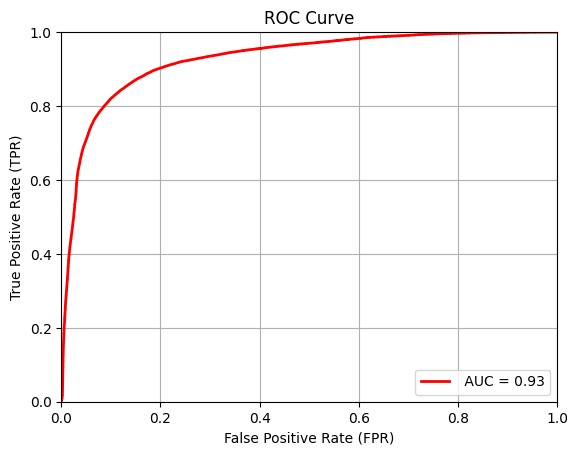

In [32]:
Plotting.plot_roc_curve(tanimoto_trans_binary, scores_trans)

In [35]:
temp_molecule_pairs.prediction = scores_trans

In [33]:
Plotting.plot_n_roc_curves(y_true_list= [tanimoto_spec2vec_binary, tanimotos_ms2_binary, tanimoto_trans_binary],
                           y_scores_list=[scores_spec2vec, scores_ms2, scores_trans],
                           labels=[f'Spec2vec  r={spearman_spec2vec[0]:.2f} ', 
                                   f'Ms2deepscore r={spearman_ms2[0]:.2f} ', 
                                   f'Simba r={spearman_trans[0]:.2f} '],
                           colors = ['r','b','k'])

NameError: name 'tanimoto_spec2vec_binary' is not defined

In [36]:
## Separate false positives

In [60]:
molecule_fp = [m for m,s in zip(temp_molecule_pairs, scores_trans) if (s>THRESHOLD_ANALOG)and (m.similarity<THRESHOLD_ANALOG)]

In [61]:
molecule_tp = [m for m,s in zip(temp_molecule_pairs, scores_trans) if (s>THRESHOLD_ANALOG)and (m.similarity>THRESHOLD_ANALOG)]

In [62]:
molecule_tn = [m for m,s in zip(temp_molecule_pairs, scores_trans) if (s<THRESHOLD_ANALOG)and (m.similarity<THRESHOLD_ANALOG)]

In [63]:
molecule_fn = [m for m,s in zip(temp_molecule_pairs, scores_trans) if (s<THRESHOLD_ANALOG)and (m.similarity>THRESHOLD_ANALOG)]

In [64]:
## There is a difference in precursor mass difference?

In [96]:
diff_mass_fp = [abs(m.spectrum_object_1.precursor_mz - m.spectrum_object_0.precursor_mz) for m in molecule_fp]

In [97]:
diff_mass_tp = [abs(m.spectrum_object_1.precursor_mz - m.spectrum_object_0.precursor_mz) for m in molecule_tp]

In [98]:
diff_mass_tn = [abs(m.spectrum_object_1.precursor_mz - m.spectrum_object_0.precursor_mz) for m in molecule_tn]

In [99]:
diff_mass_fn = [abs(m.spectrum_object_1.precursor_mz - m.spectrum_object_0.precursor_mz) for m in molecule_fn]

In [84]:
diff_mass_positives= diff_mass_tp + diff_mass_fn
diff_mass_negatives = diff_mass_tn + diff_mass_fp

In [80]:
len(molecule_tp), len(molecule_fn)

(39185, 10235)

In [81]:
len(molecule_tn), len(molecule_fp)

(124554, 11182)

Text(0.5, 0, 'diff mass')

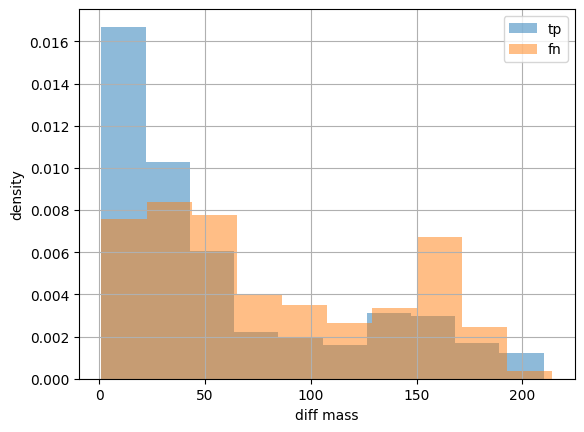

In [91]:
_= plt.hist(diff_mass_tp, label ='tp', alpha=0.5,bins=10, density=True)
_= plt.hist(diff_mass_fn, label ='fn', alpha=0.5,bins=10, density=True)
plt.legend()
plt.grid()
plt.ylabel('density')
plt.xlabel('diff mass')

Text(0.5, 0, 'diff mass')

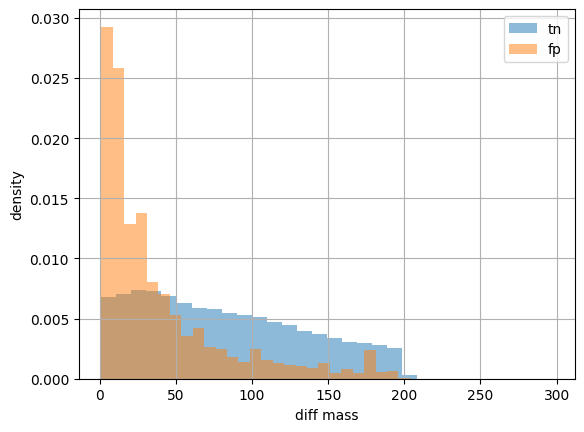

In [78]:
_=plt.hist(diff_mass_tn, label='tn', alpha=0.5, bins=30,density=True)
_= plt.hist(diff_mass_fp, label ='fp', alpha=0.5,bins=30, density=True)
plt.legend()
plt.grid()
plt.ylabel('density')
plt.xlabel('diff mass')

Text(0.5, 0, 'diff mass')

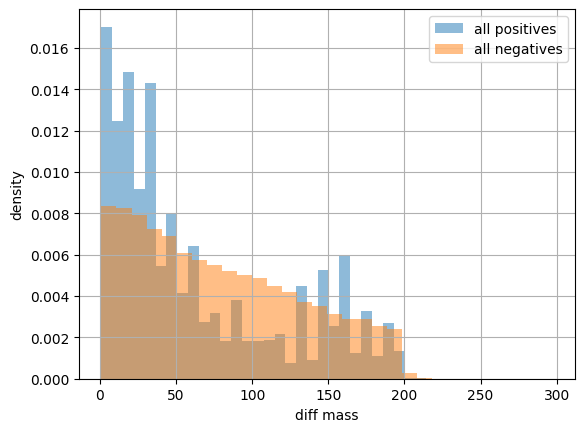

In [90]:
_=plt.hist(diff_mass_positives, label='all positives', alpha=0.5, bins=30,density=True)
_= plt.hist(diff_mass_negatives, label ='all negatives', alpha=0.5,bins=30, density=True)
plt.legend()
plt.grid()
plt.ylabel('density')
plt.xlabel('diff mass')

In [ ]:
all_negatives= 

(array([2.6088e+04, 2.5138e+04, 2.1117e+04, 1.8693e+04, 1.4923e+04,
        1.1632e+04, 6.9380e+03, 1.9000e+01, 0.0000e+00, 6.0000e+00]),
 array([  1.0004 ,  30.61544,  60.23048,  89.84552, 119.46056, 149.0756 ,
        178.69064, 208.30568, 237.92072, 267.53576, 297.1508 ]),
 <BarContainer object of 10 artists>)

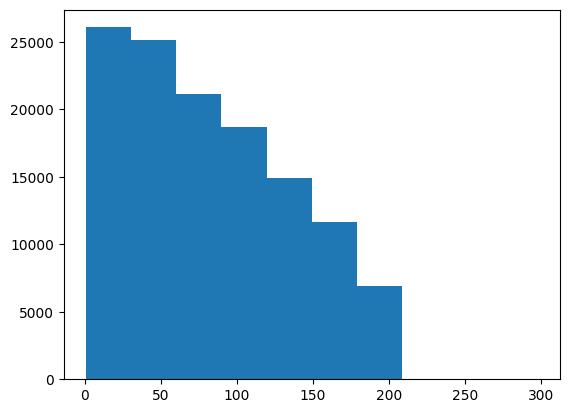

In [70]:
plt.hist(diff_mass_tn)

(array([1654., 1832., 1699.,  882.,  762.,  582.,  732., 1472.,  537.,
          83.]),
 array([  1.0055 ,  22.32515,  43.6448 ,  64.96445,  86.2841 , 107.60375,
        128.9234 , 150.24305, 171.5627 , 192.88235, 214.202  ]),
 <BarContainer object of 10 artists>)

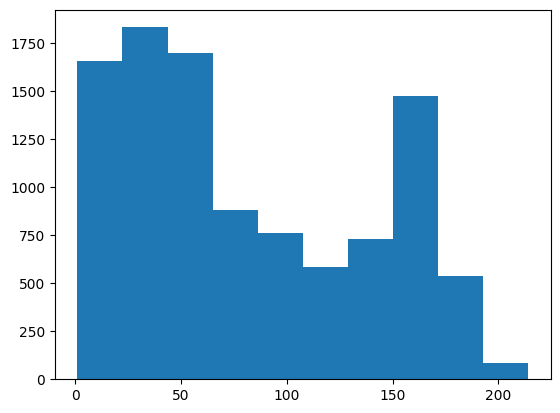

In [53]:
plt.hist(diff_mass_fn)

In [100]:
## Where the errors are ocurring more?
mass_fp = [min(m.spectrum_object_1.precursor_mz,m.spectrum_object_0.precursor_mz) for m in molecule_fp]

In [101]:
mass_tp = [min(m.spectrum_object_1.precursor_mz,m.spectrum_object_0.precursor_mz) for m in molecule_tp]

In [102]:
mass_tn = [min(m.spectrum_object_1.precursor_mz,m.spectrum_object_0.precursor_mz) for m in molecule_tn]

In [103]:
mass_fn = [min(m.spectrum_object_1.precursor_mz,m.spectrum_object_0.precursor_mz) for m in molecule_fn]

Text(0.5, 0, 'mass')

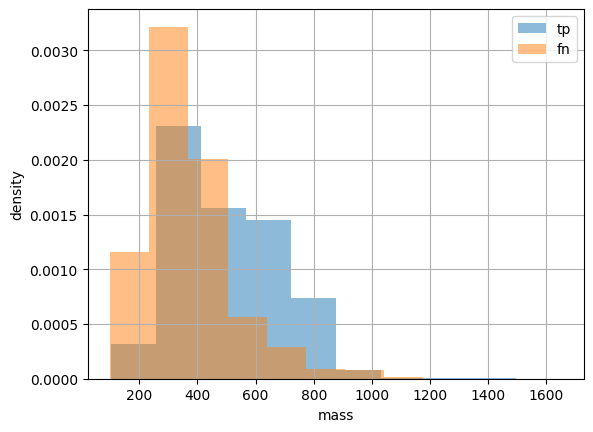

In [109]:
_= plt.hist(mass_tp, label ='tp', alpha=0.5,bins=10, density=True)
_= plt.hist(mass_fn, label ='fn', alpha=0.5,bins=10, density=True)
plt.legend()
plt.grid()
plt.ylabel('density')
plt.xlabel('mass')

Text(0.5, 0, 'mass')

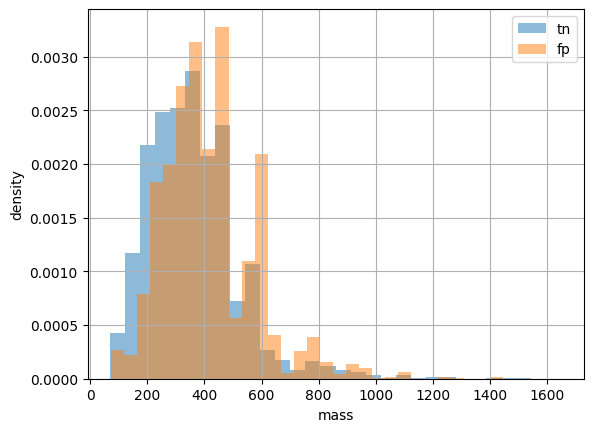

In [108]:
_=plt.hist(mass_tn, label='tn', alpha=0.5, bins=30,density=True)
_= plt.hist(mass_fp, label ='fp', alpha=0.5,bins=30, density=True)
plt.legend()
plt.grid()
plt.ylabel('density')
plt.xlabel('mass')

Text(0.5, 0, 'mass')

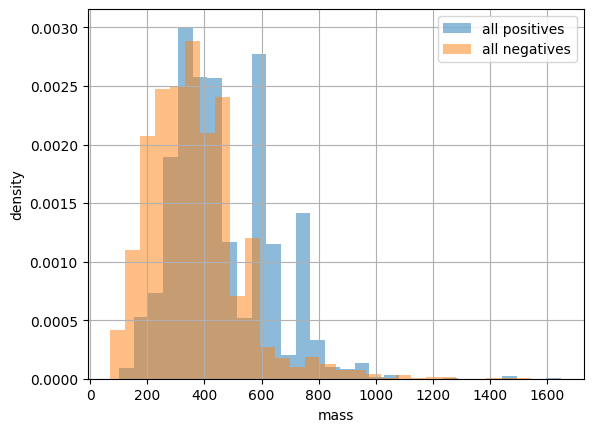

In [107]:
_=plt.hist(mass_tp + mass_fn, label='all positives', alpha=0.5, bins=30,density=True)
_= plt.hist(mass_tn + mass_fp, label ='all negatives', alpha=0.5,bins=30, density=True)
plt.legend()
plt.grid()
plt.ylabel('density')
plt.xlabel('mass')

Text(0.5, 0, 'mass')

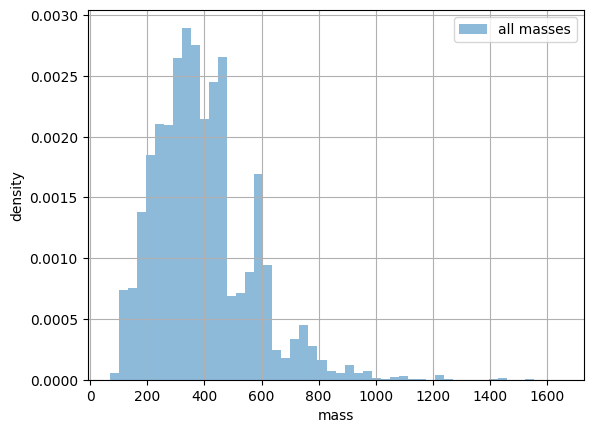

In [118]:
##all masses
_=plt.hist(mass_tp + mass_fn+mass_tn + mass_fp, label='all masses', alpha=0.5, bins=50,density=True)
plt.legend()
plt.grid()
plt.ylabel('density')
plt.xlabel('mass')

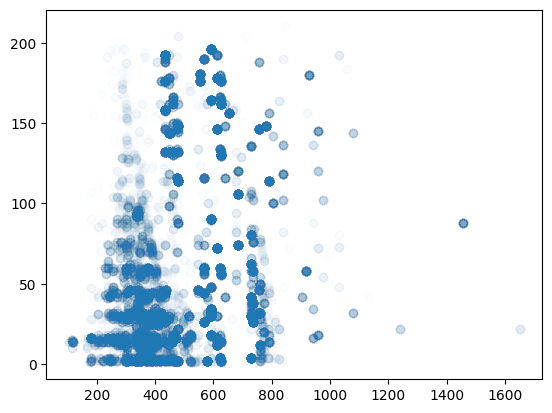

In [116]:
plt.scatter(mass_tp,diff_mass_tp, alpha=0.01)

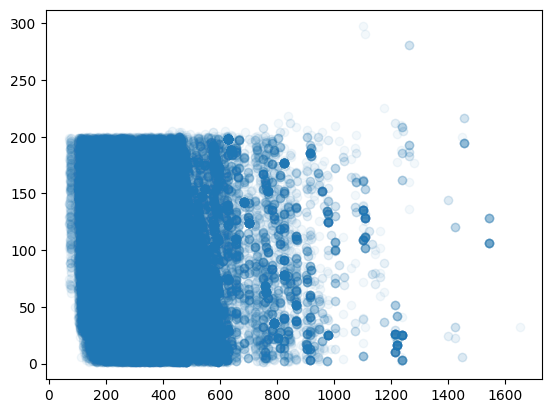

In [115]:
plt.scatter(mass_tn,diff_mass_tn, alpha=0.05)